In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression, SelectKBest

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

### Querying product sales from GA

In [2]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '5'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) as ymd
        ,product_id
        ,product_name
        ,product_category product_category_temp
        ,product_price
        ,sum(product_qty) as daily_qty
        ,count(distinct user_id) as daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
daily_sales.shape


(49069, 7)

In [3]:
daily_sales = rows.to_dataframe()
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
# daily_sales["month"] = daily_sales["year_month"].dt.strftime("%b")
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Electronics', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)
daily_sales

,ymd,product_id,product_price,product_category,daily_qty,daily_user_cnt
0,2016-08-01,GGOEAAEH035214,23.99,Apparel,3,1
1,2016-08-01,GGOEAAWQ063048,27.19,Apparel,4,1
2,2016-08-01,GGOEAAXN066355,13.59,Apparel,3,1
3,2016-08-01,GGOEAAYC068756,15.19,Apparel,4,1
4,2016-08-01,GGOEADHH015499,575.70,Drinkware,90,1
...,...,...,...,...,...,...
48771,2017-07-31,GGOEYFKQ020699,1.59,Office,3,2
48772,2017-07-31,GGOEYFKQ020699,1.99,Office,3,3
48773,2017-07-31,GGOEYHPB072210,10.99,Headgear,2,1
48774,2017-07-31,GGOEYOCR077799,11.99,Notebooks & Journals,2,1


### Generating synthetic data for Mar - Jul 2016

In [4]:
import itertools
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])

def get_month_products(dates, month, product_prices, sales):
    date_product_price_df = pd.DataFrame(
        list(itertools.product(dates, product_prices.to_records(index=False))),
        columns=['ymd', 'product_price_pair']
    )
    date_product_price_df['product_id'] = date_product_price_df['product_price_pair'].apply(lambda x: x[0])
    date_product_price_df['product_price'] = date_product_price_df['product_price_pair'].apply(lambda x: x[1])
    date_product_price_df.drop({'product_price_pair'}, axis = 1, inplace = True)
    month_sales = pd.merge(date_product_price_df, daily_sales, how='left', on=['ymd', 'product_id', 'product_price']).fillna(0)

    return pd.concat([sales, month_sales], axis=0)

mar_dates = pd.date_range(start='2017-03-01',  end='2017-03-31', freq ='D')
mar_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 3, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
apr_dates = pd.date_range(start='2017-04-01',  end='2017-04-30', freq ='D')
apr_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 4, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
may_dates = pd.date_range(start='2017-05-01',  end='2017-05-31', freq ='D')
may_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 5, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
jun_dates = pd.date_range(start='2017-06-01',  end='2017-06-30', freq ='D')
jun_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 6, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
jul_dates = pd.date_range(start='2017-07-01',  end='2017-07-31', freq ='D')
jul_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 7, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()

mar_jul_sales = pd.DataFrame()
mar_jul_sales = get_month_products(mar_dates, 3, mar_product_prices, mar_jul_sales)
print(mar_jul_sales)
mar_jul_sales = get_month_products(apr_dates, 4, apr_product_prices, mar_jul_sales)
print(mar_jul_sales.shape)
mar_jul_sales = get_month_products(may_dates, 5, may_product_prices, mar_jul_sales)
print(mar_jul_sales.shape)
mar_jul_sales = get_month_products(jun_dates, 6, jun_product_prices, mar_jul_sales)
print(mar_jul_sales.shape)
mar_jul_sales = get_month_products(jul_dates, 7, jul_product_prices, mar_jul_sales)
print(mar_jul_sales.shape)

             ymd      product_id  product_price      product_category  daily_qty  daily_user_cnt
0     2017-03-01  GGOEAAQB036114          44.79               Apparel          1               1
1     2017-03-01  GGOEAAWC061653          19.19               Apparel          1               1
2     2017-03-01  GGOEAAWH061553          57.57               Apparel          3               1
3     2017-03-01  GGOEAAWT061753          23.99               Apparel          1               1
4     2017-03-01  GGOEAAYC068756          15.19               Apparel          1               1
...          ...             ...            ...                   ...        ...             ...
71605 2017-03-31  GGOEGOCB017499          87.90  Notebooks & Journals         10               1
71606 2017-03-31  GGOEGOCC017599          95.70  Notebooks & Journals         30               1
71607 2017-03-31  GGOEGOXQ016399           3.18                Office          6               1
71608 2017-03-31  GGOEGPJC0190

In [ ]:
np.random.seed(123)
synthetic_data = pd.DataFrame()

months = [3, 4, 5, 6, 7]

for month in months:
    products = mar_jul_sales[mar_jul_sales['ymd'].dt.month == month]['product_id'].unique()
    for product in products:
        prices = mar_jul_sales[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product)]['product_price'].unique()
        for price in prices:

            monthly_sales_qty = mar_jul_sales.loc[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product) & (mar_jul_sales['product_price'] == price), ['daily_qty']]
            monthly_sales_user_cnt = mar_jul_sales.loc[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product) & (mar_jul_sales['product_price'] == price), ['daily_user_cnt']]

            n_train = monthly_sales_qty.shape[0]
 
            m = mar_jul_sales.loc[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product) & (mar_jul_sales['product_price'] == price)]
            print(f'price {price} for product {product} for month {month} with {m['daily_qty'].sum()} in month and {m['daily_user_cnt'].sum()} users')

            m['daily_avg_qty'] = m.apply(lambda row: row['daily_qty'] / row['daily_user_cnt'] if row['daily_user_cnt'] > 0 else 0, axis=1)
            lambda_qty = m['daily_qty'].mean()
            lambda_user_cnt = m['daily_user_cnt'].mean()
            lambda_avg_qty = m['daily_avg_qty'].mean()
            lambda_avg_qty_i = np.random.poisson(lambda_avg_qty)
            sample_qty = np.random.poisson(lambda_qty, n_train)
            sample_user_cnt = np.random.poisson(lambda_user_cnt, n_train)
            print(f'qty: {sample_qty.sum()}, user: {sample_user_cnt.sum()}')

            if (sample_user_cnt.sum() == 0 and sample_qty.sum() != 0) or (sample_user_cnt.sum() != 0 and sample_qty.sum() == 0):
                # print(f'dividing {sample_qty.sum()} by {lambda_avg_qty_i}')
                # if lambda_avg_qty_i == 0:
                #     sample_user_cnt_spec = 0
                #     sample_qty_spec = 0
                # else:
                #     sample_user_cnt_spec = (sample_qty.sum()//(lambda_avg_qty_i)).astype(int)
                #     sample_qty_spec = sample_qty.sum()
                #     if sample_user_cnt_spec == 0:
                #         sample_qty_spec = 0
                
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': 0, 'present_total_qty': 0})
                print(f'qty: 0, user: 0')

            elif sample_user_cnt.sum() > sample_qty.sum():
                sample_user_cnt_spec = sample_user_cnt.sum()
                print(f'multiplying {sample_user_cnt.sum()} by {lambda_avg_qty_i}')
                sample_qty_spec = (sample_user_cnt.sum()*(lambda_avg_qty_i)).astype(int)
                if sample_qty_spec == 0:
                    sample_user_cnt_spec = 0
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': sample_user_cnt_spec, 'present_total_qty': sample_qty_spec})
                print(f'qty: {sample_qty_spec}, user: {sample_user_cnt_spec}')
            else:
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': sample_user_cnt.sum(), 'present_total_qty': sample_qty.sum()})
 
            synthetic_data = pd.concat([synthetic_data, month_data], ignore_index = True)

synthetic_data

#### Checking distribution of synthetic data

In [219]:
t = mar_jul_sales.copy()
t['year_month'] = t['ymd'].dt.strftime('%Y-%m')
t = t.groupby(['year_month', 'product_category'])[['daily_qty', 'daily_user_cnt']].sum().reset_index()
t = t.loc[t['product_category'] != 0]
t.rename({'daily_qty': 'present_total_qty', 'daily_user_cnt': 'present_user_cnt'}, axis = 1, inplace = True)

t2 = synthetic_data.copy()
t2 = pd.merge(t2, daily_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on = ['product_id', 'product_price'], how = 'left')
t2 = t2.groupby(['year_month', 'product_category'])[['present_user_cnt', 'present_total_qty']].sum().reset_index()
t2['year_month'] = pd.to_datetime(t2['year_month']).dt.strftime(('%Y-%m'))
t3 = pd.concat([t, t2], axis = 0)
t3['year'] = t3['year_month'].str[:4]

In [220]:
t3

,year_month,product_category,present_total_qty,present_user_cnt,year
1,2017-03,Accessories,398,26,2017
2,2017-03,Apparel,16693,1942,2017
3,2017-03,Bags,2500,285,2017
4,2017-03,Drinkware,6820,599,2017
5,2017-03,Electronics,2702,248,2017
...,...,...,...,...,...
55,2016-07,Headgear,903,257,2016
56,2016-07,Housewares,1231,18,2016
57,2016-07,Lifestyle,6203,390,2016
58,2016-07,Notebooks & Journals,4475,234,2016


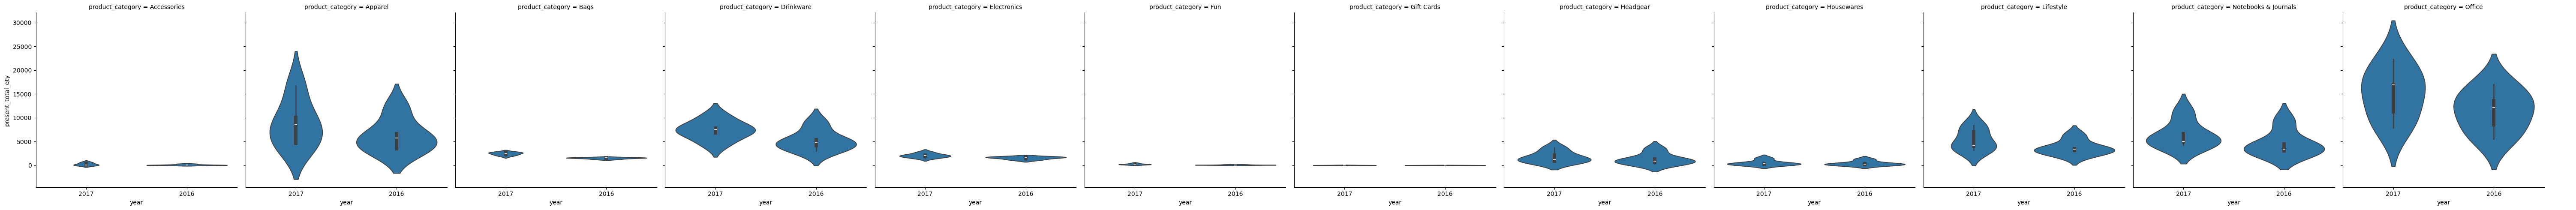

In [221]:
sns.catplot(y = 'present_total_qty', data = t3, col = 'product_category', x = 'year', kind = 'violin')

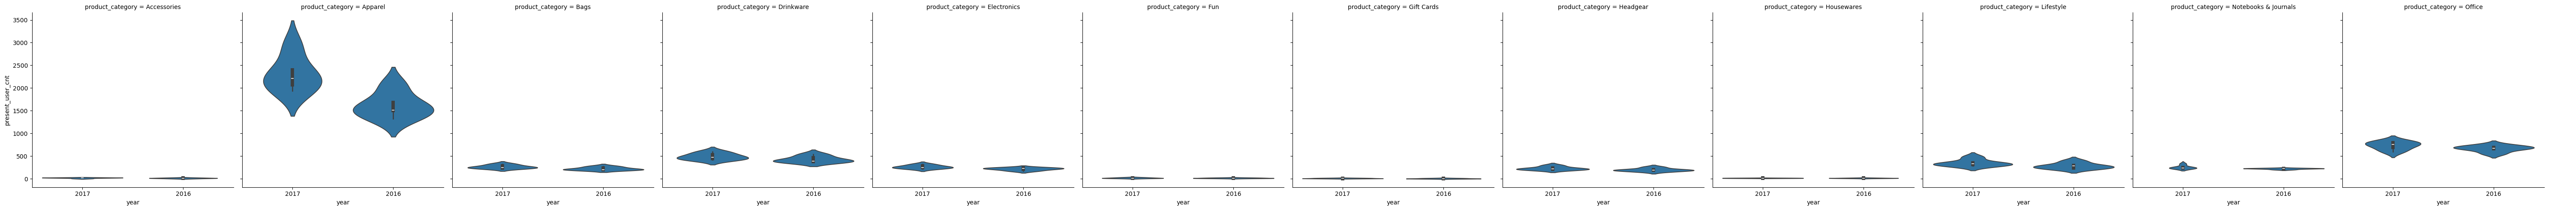

In [222]:
sns.catplot(y = 'present_user_cnt', data = t3, col = 'product_category', x = 'year', kind = 'violin')

In [223]:
synthetic_data = pd.merge(synthetic_data, daily_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on = ['product_id', 'product_price'], how = 'left')
column_order = ['year_month', 'product_id', 'product_category', 'product_price', 'present_user_cnt', 'present_total_qty']
synthetic_data = synthetic_data[column_order]
synthetic_data['year_month'] = pd.to_datetime(synthetic_data['year_month']).dt.strftime('%Y-%m')
synthetic_data

,year_month,product_id,product_category,product_price,present_user_cnt,present_total_qty
0,2016-03,GGOEAAQB036114,Apparel,44.79,0,0
1,2016-03,GGOEAAWC061653,Apparel,19.19,2,2
2,2016-03,GGOEAAWH061553,Apparel,57.57,0,0
3,2016-03,GGOEAAWH061553,Apparel,19.19,0,0
4,2016-03,GGOEAAWT061753,Apparel,23.99,1,3
...,...,...,...,...,...,...
11012,2016-07,GGOEGATJ060515,Apparel,30.00,0,0
11013,2016-07,GGOEAAEJ030916,Apparel,12.00,0,0
11014,2016-07,GGOEGAAQ057213,Apparel,34.99,1,2
11015,2016-07,GGOEYAEJ029015,Apparel,18.99,0,0


#### Joining synthetic data to original data

In [11]:
# synthetic_data.to_csv('synthetic_mar_jul_sales_data_v2.csv', index=False)
synthetic_data = pd.read_csv('synthetic_mar_jul_sales_data_v2.csv')

In [12]:
daily_sales['year_month'] = daily_sales['ymd'].dt.strftime('%Y-%m')
monthly_sales = daily_sales.groupby(['year_month','product_id', 'product_category', 'product_price'])[['daily_qty', 'daily_user_cnt']].sum().reset_index()
monthly_sales.rename({'daily_qty': 'present_total_qty', 'daily_user_cnt': 'present_user_cnt'}, axis=1, inplace=True)
all_monthly_sales = pd.concat([monthly_sales, synthetic_data], ignore_index = True)
all_monthly_sales

,year_month,product_id,product_category,product_price,present_total_qty,present_user_cnt
0,2016-08,GGOEAAAB034813,Apparel,16.99,13,1
1,2016-08,GGOEAAAB034814,Apparel,13.59,7,3
2,2016-08,GGOEAAAB034814,Apparel,16.99,2,1
3,2016-08,GGOEAAAB034815,Apparel,13.59,1,1
4,2016-08,GGOEAAAB034815,Apparel,16.99,10,1
...,...,...,...,...,...,...
34999,2016-07,GGOEGATJ060515,Apparel,30.00,0,0
35000,2016-07,GGOEAAEJ030916,Apparel,12.00,0,0
35001,2016-07,GGOEGAAQ057213,Apparel,34.99,2,1
35002,2016-07,GGOEYAEJ029015,Apparel,18.99,0,0


### Data cleaning

In [53]:
# Make sure that each product-price pair appears in all months
all_months = pd.date_range(start='2016-03-01', end='2017-07-01', freq='MS')
unique_products = all_monthly_sales['product_id'].drop_duplicates()
months_products_combos = pd.MultiIndex.from_product([unique_products, all_months], names=['product_id', 'year_month'])
months_products_combos = pd.DataFrame(index = months_products_combos).reset_index()
months_products_combos['year_month'] = pd.to_datetime(months_products_combos['year_month']).dt.strftime('%Y-%m')
months_products_price = pd.merge(months_products_combos, all_monthly_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on  = 'product_id', how = 'left')
all_months_products = pd.merge(months_products_price, all_monthly_sales, on = ['product_id', 'product_price', 'year_month','product_category'], how = 'left')

all_months_products[['present_total_qty', 'present_user_cnt']] = all_months_products[['present_total_qty', 'present_user_cnt']].fillna(0)
all_months_products['year_month'] = pd.to_datetime(all_months_products['year_month'])
all_months_products['month'] = all_months_products['year_month'].dt.strftime('%b')


### Feature engineering 1

In [ ]:
qty_sd = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].std().reset_index(name = 'total_qty_sd')
user_cnt_sd = all_months_products.groupby(['product_id', 'product_price'])['present_user_cnt'].std().reset_index(name = 'user_cnt_sd')

all_months_products = all_months_products.merge(qty_sd, on = ['product_id', 'product_price'], how = 'left')
all_months_products = all_months_products.merge(user_cnt_sd, on = ['product_id', 'product_price'], how = 'left')

all_months_products['total_qty_log'] = np.log1p(all_months_products['present_total_qty'])

### EDA

<Axes: xlabel='present_total_qty', ylabel='Density'>

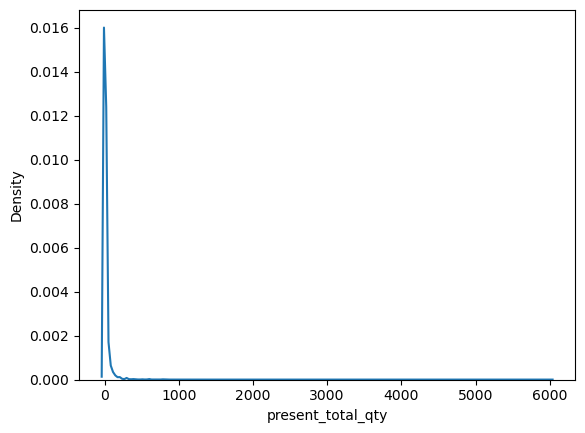

In [ ]:
sns.kdeplot(data = all_monthly_sales, x = 'present_total_qty')

<Axes: xlabel='total_qty_log', ylabel='Density'>

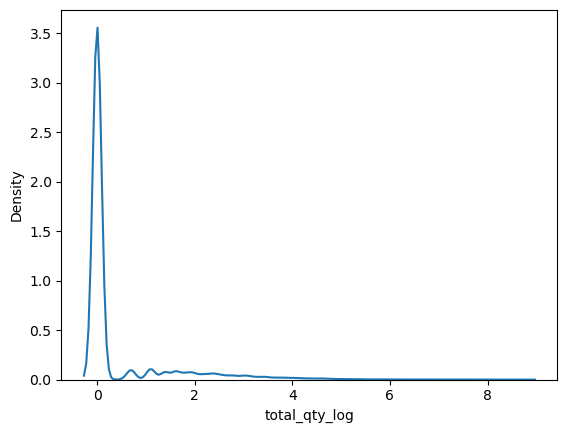

In [45]:
sns.kdeplot(data = all_months_products, x = 'total_qty_log')

<Axes: xlabel='total_qty_sd', ylabel='Density'>

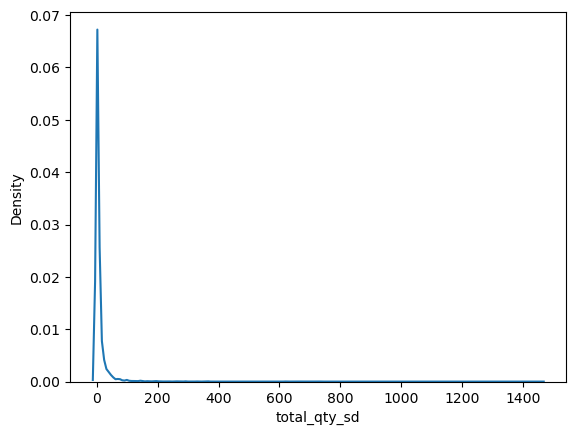

In [46]:
sns.kdeplot(data = all_months_products, x = 'total_qty_sd')

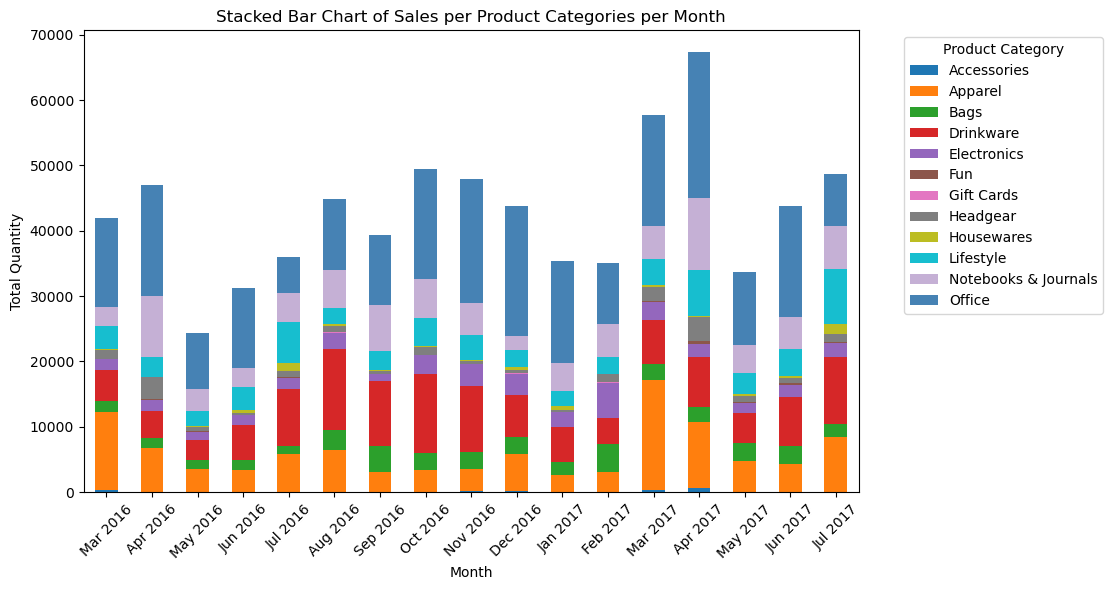

In [ ]:
colors = [
    '#1f77b4',  # Muted Blue
    '#ff7f0e',  # Muted Orange
    '#2ca02c',  # Muted Green
    '#d62728',  # Muted Red
    '#9467bd',  # Muted Purple
    '#8c564b',  # Brownish
    '#e377c2',  # Soft Pink
    '#7f7f7f',  # Medium Grey
    '#bcbd22',  # Olive Green
    '#17becf',  # Teal
    '#c5b0d5',  # Soft Lavender
    '#4682b4'   # Steel Blue (replacing Khaki)
]

ax1 = all_months_products.groupby(['year_month', 'product_category'])['present_total_qty'].sum().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color = colors)
ax1.set_xticklabels(all_months_products['year_month'].dt.strftime('%b %Y').unique())
plt.ylabel('Total Quantity')
plt.xlabel('Month')
plt.title('Stacked Bar Chart of Sales per Product Categories per Month')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')


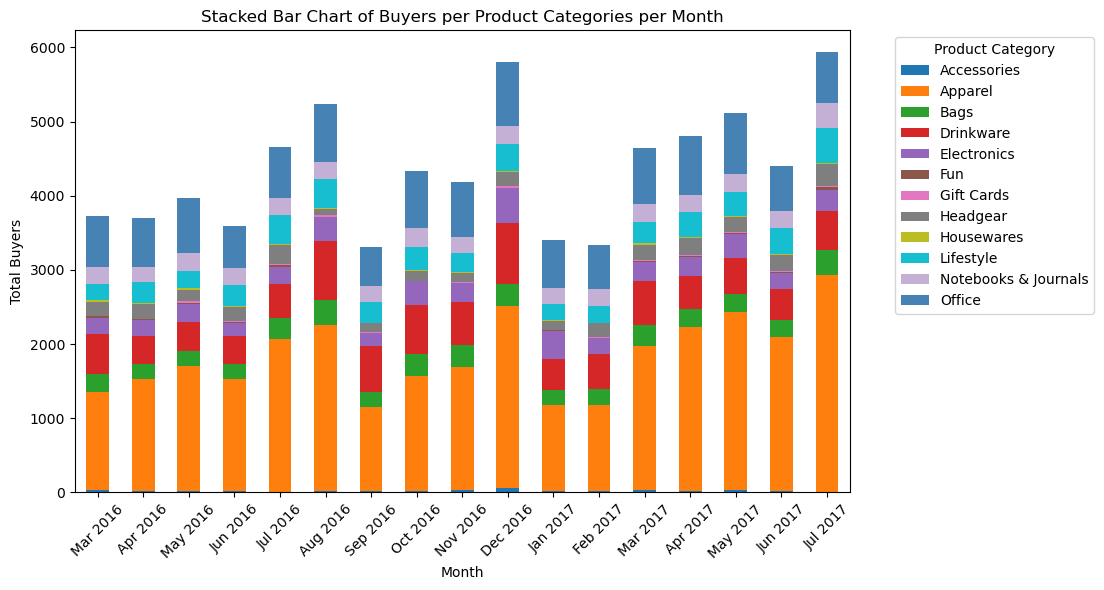

In [ ]:
ax2 = all_months_products.groupby(['year_month', 'product_category'])['present_user_cnt'].sum().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color = colors)
ax2.set_xticklabels(all_months_products['year_month'].dt.strftime('%b %Y').unique())
plt.ylabel('Total Buyers')
plt.xlabel('Month')
plt.title('Stacked Bar Chart of Buyers per Product Categories per Month')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

Text(0, 0.5, 'Product Category')

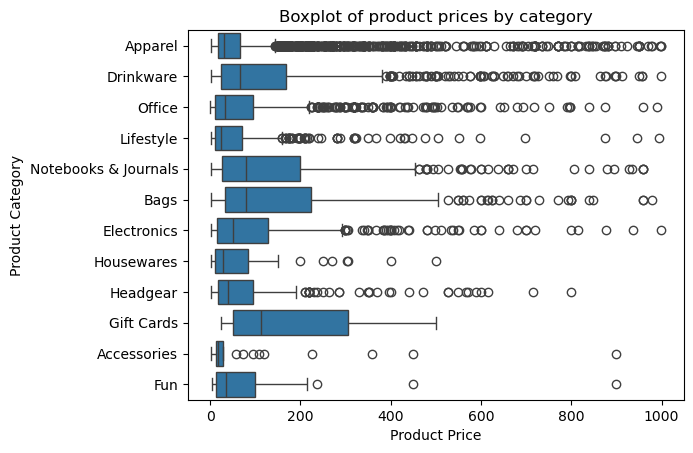

In [22]:
product_prices = all_months_products[['product_category', 'product_id', 'product_price']].drop_duplicates()
sns.boxplot(x = product_prices['product_price'], y = product_prices['product_category'])
plt.title('Boxplot of product prices by category')
plt.xlabel('Product Price')
plt.ylabel('Product Category')

Text(0, 0.5, 'Product Category')

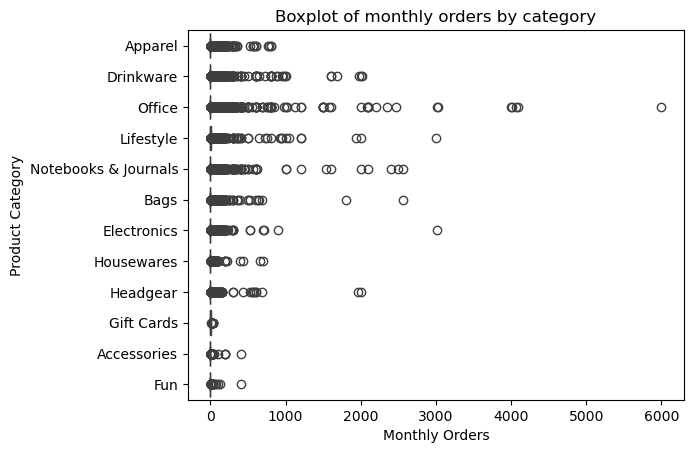

In [23]:
sns.boxplot(x = all_months_products['present_total_qty'], y = all_months_products['product_category'])
plt.title('Boxplot of monthly orders by category')
plt.xlabel('Monthly Orders')
plt.ylabel('Product Category')

Text(0, 0.5, 'Product Category')

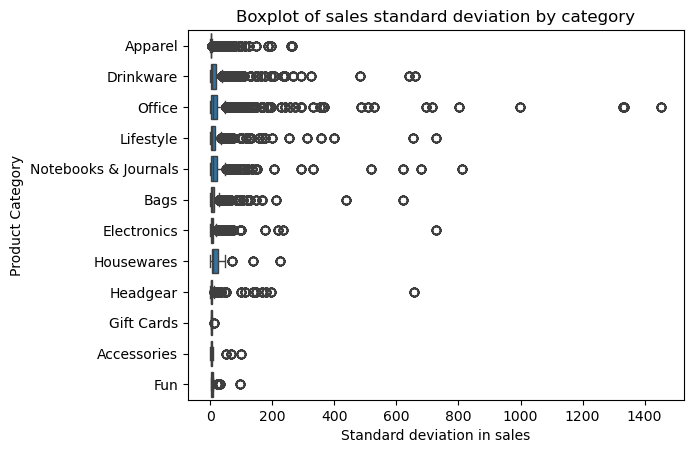

In [33]:
sns.boxplot(x = all_months_products['total_qty_sd'], y = all_months_products['product_category'])
plt.title('Boxplot of sales standard deviation by category')
plt.xlabel('Standard deviation in sales')
plt.ylabel('Product Category')

Text(0, 0.5, 'Product Category')

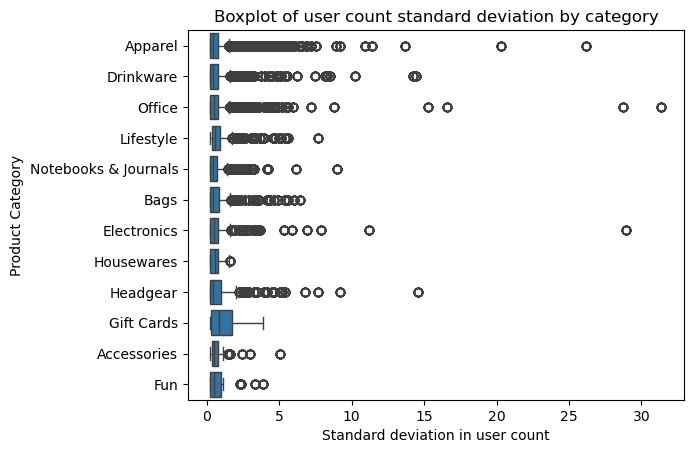

In [34]:
sns.boxplot(x = all_months_products['user_cnt_sd'], y = all_months_products['product_category'])
plt.title('Boxplot of user count standard deviation by category')
plt.xlabel('Standard deviation in user count')
plt.ylabel('Product Category')

### Feature engineering

##### Lag quantity and user count

In [71]:
#Create columns for lag qty, lag user count, rolling window avg qty & rolling window  user count
all_months_products = all_months_products.sort_values(['product_id', 'product_price', 'year_month'])
all_months_products['prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(1)
all_months_products['prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(1)
all_months_products['prev_prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(2)
all_months_products['prev_prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(2)
all_months_products['prev_prev_prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(3)
all_months_products['prev_prev_prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(3)
all_months_products.dropna(inplace = True)
all_months_products['avg_2m_user_cnt'] = (all_months_products['prev_user_cnt'] + all_months_products['prev_prev_user_cnt'])/2
all_months_products['avg_3m_user_cnt'] = (all_months_products['prev_user_cnt'] + all_months_products['prev_prev_user_cnt'] + all_months_products['prev_prev_prev_user_cnt'])/3
all_months_products['avg_2m_total_qty'] = (all_months_products['prev_total_qty'] + all_months_products['prev_prev_total_qty'])/2
all_months_products['avg_3m_total_qty'] = (all_months_products['prev_total_qty'] + all_months_products['prev_prev_total_qty'] + all_months_products['prev_prev_prev_total_qty'])/3
all_months_products[['product_price','avg_2m_user_cnt','avg_3m_user_cnt','avg_2m_total_qty','avg_3m_total_qty']] = all_months_products[['product_price','avg_2m_user_cnt','avg_3m_user_cnt','avg_2m_total_qty','avg_3m_total_qty']].apply(lambda x: x.round(2), axis = 0)

<Axes: >

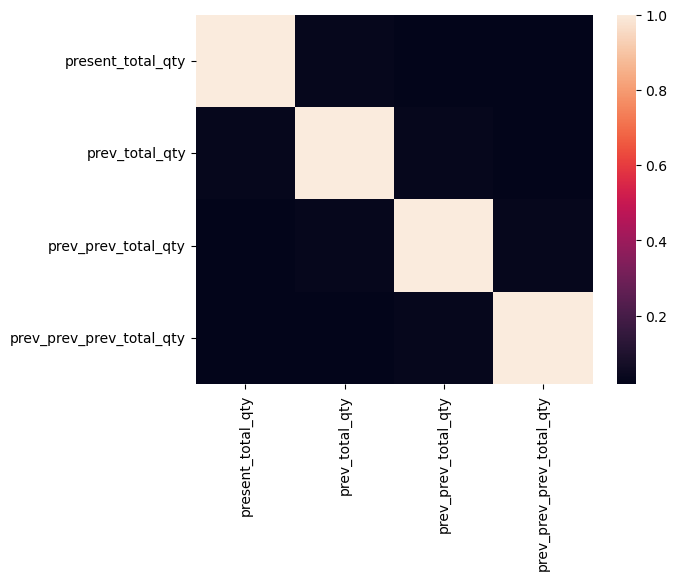

In [198]:
qty_corr = all_months_products[['present_total_qty', 'prev_total_qty', 'prev_prev_total_qty','prev_prev_prev_total_qty']].corr()
sns.heatmap(qty_corr)

##### Indicators for holidays/peak periods

In [72]:
#Add indicators for holidays/peak periods (https://quivo.co/us/amazon-peak-season-most-important-e-commerce-days-2024/)
all_months_products["peak_period"] = all_months_products["month"].isin(["Nov", "Dec"]).astype(int)
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
holidays = [0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1]
month_holidays = pd.DataFrame({"month": month, "holidays": holidays})
all_months_products = all_months_products.merge(month_holidays, on = "month", how = "left")

##### Variation in demand (XYZ analysis)

In [75]:
qty_sd = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].std().reset_index(name = 'total_qty_sd')
qty_mean = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].mean().reset_index(name = 'total_qty_mean')
qty_stats = pd.merge(qty_sd, qty_mean, on = ['product_id', 'product_price'], how = 'left')
qty_stats['total_qty_cv'] = qty_stats['total_qty_sd']/qty_stats['total_qty_mean']

user_cnt_sd = all_months_products.groupby(['product_id', 'product_price'])['present_user_cnt'].std().reset_index(name = 'user_cnt_sd')
user_cnt_mean = all_months_products.groupby(['product_id', 'product_price'])['present_user_cnt'].mean().reset_index(name = 'user_cnt_mean')
user_cnt_stats = pd.merge(user_cnt_sd, user_cnt_mean, on = ['product_id', 'product_price'], how = 'left')
user_cnt_stats['user_cnt_cv'] = user_cnt_stats['user_cnt_sd']/user_cnt_stats['user_cnt_mean']

all_months_products = all_months_products.merge(qty_stats, on = ['product_id', 'product_price'], how = 'left')
all_months_products = all_months_products.merge(user_cnt_stats, on = ['product_id', 'product_price'], how = 'left')
all_months_products['total_qty_log'] = np.log1p(all_months_products['present_total_qty'])

<Axes: xlabel='total_qty_cv', ylabel='Density'>

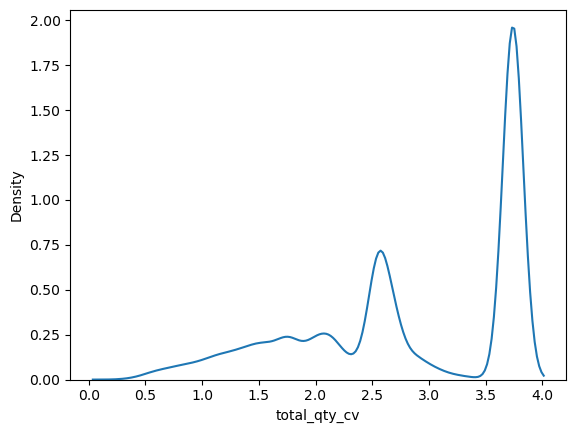

In [76]:
sns.kdeplot(x = 'total_qty_cv', data = all_months_products)

In [77]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(all_months_products[['total_qty_cv']])
labels = kmeans.labels_
all_months_products['xyz_cat'] = labels

<Axes: xlabel='xyz_cat', ylabel='total_qty_cv'>

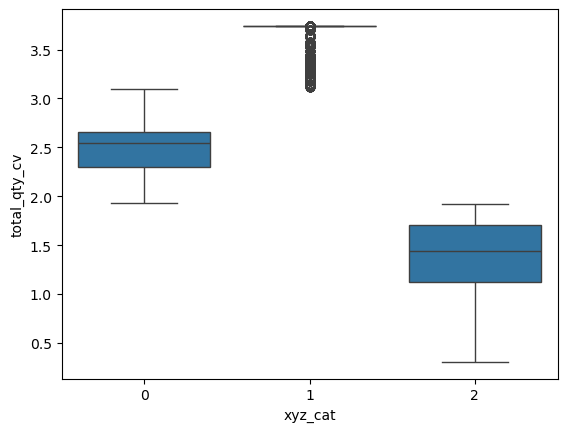

In [78]:
sns.boxplot(data = all_months_products, x = 'xyz_cat', y = 'total_qty_cv')

<Axes: xlabel='xyz_cat', ylabel='total_qty_cv'>

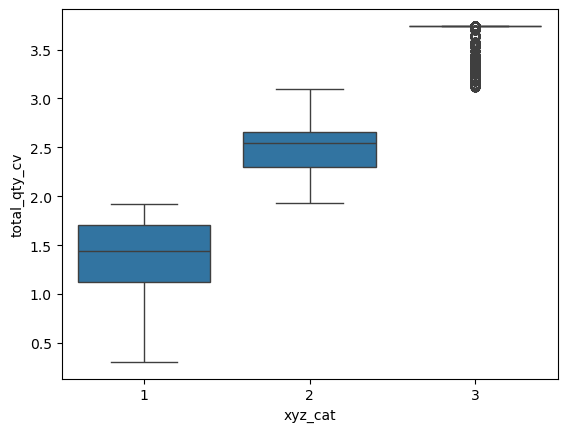

In [92]:
all_months_products['xyz_cat'] = all_months_products['xyz_cat'].replace({0:2, 1:3, 2:1})
sns.boxplot(data = all_months_products, x = 'xyz_cat', y = 'total_qty_cv')

### Feature selection

In [93]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

model_df = all_months_products.copy()
test_df = model_df.loc[model_df["year_month"] == '2017-07-01']
val_df = model_df.loc[model_df["year_month"] == '2017-06-01']
train_df = model_df.loc[~model_df["year_month"].isin(['2017-07-01', '2017-06-01'])]

all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

X_train = train_df[['month','product_id', 'product_category', 'product_price', 'holidays','xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt', 'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty', 'avg_3m_total_qty']]
X_train['month'] = pd.Categorical(X_train['month'], categories = all_months)
X_train = pd.get_dummies(X_train, columns = ['product_category', 'product_id', 'month'])
y_train = train_df['present_total_qty']

X_test = test_df[['month','product_id', 'product_category', 'product_price', 'holidays','xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt', 'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty', 'avg_3m_total_qty']]
X_test['month'] = pd.Categorical(X_test['month'], categories = all_months)
X_test = pd.get_dummies(X_test, columns = ['product_category', 'product_id', 'month'])
y_test = test_df['present_total_qty']

X_val = val_df[['month','product_id', 'product_category', 'product_price', 'holidays','xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt', 'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty', 'avg_3m_total_qty']]
X_val['month'] = pd.Categorical(X_val['month'], categories = all_months)
X_val = pd.get_dummies(X_val, columns = ['product_category', 'product_id', 'month'])
y_val = val_df['present_total_qty']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Feature selection

#### PCA

Text(0, 0.5, 'Cumulative Explained Variance (%)')

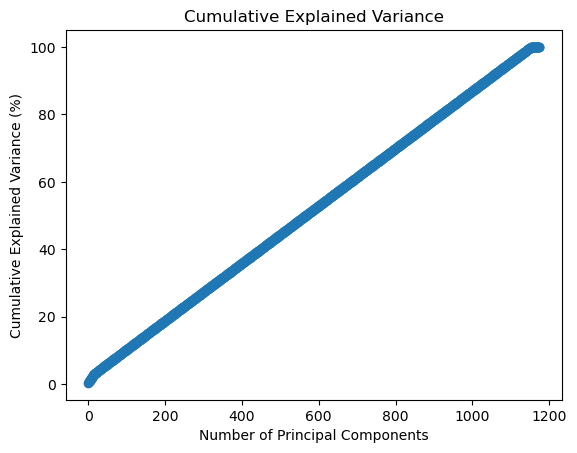

In [251]:
pca_train = PCA()
pca_train.fit(X_train_scaled)
explained_variance = pca_train.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance * 100, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')


#### ANOVA (to pick categorical)

In [90]:
from sklearn.feature_selection import f_classif, SelectKBest
X_train_cat = X_train.loc[:, (X_train.columns.str.startswith('product_category')) |(X_train.columns.str.startswith('product_id')) | (X_train.columns.str.startswith('month')) ]
F_values, p_values = f_classif(X_train_cat, y_train)

anova_results = pd.DataFrame({
    'Feature': X_train_cat.columns,
    'F-value': F_values,
    'p-value': p_values
})

# Display the results
features_keep = anova_results.loc[anova_results['p-value'] <= 0.05,'Feature'].tolist()
features_remove = anova_results.loc[anova_results['p-value'] > 0.05,'Feature'].tolist()

In [97]:
X_train_anova = X_train.loc[:, ~X_train.columns.isin(features_remove)]
X_val_anova = X_val.loc[:, ~X_val.columns.isin(features_remove)]
X_test_anova = X_test.loc[:, ~X_test.columns.isin(features_remove)]


### Model training (generally the issue is underfitting)

#### KNN

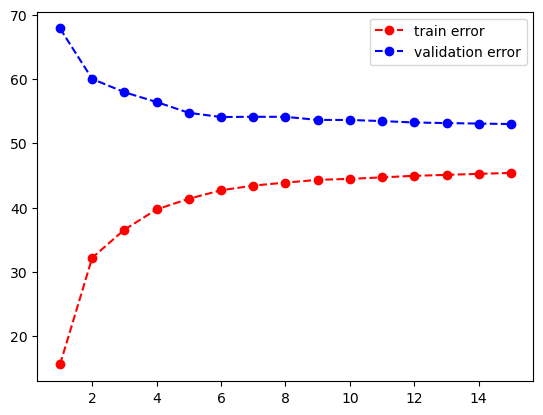

In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
X_train_small = X_train.loc[:, ~X_train.columns.str.startswith('product_id')]
X_train_scaled_small = scaler.fit_transform(X_train_small)
X_val_small = X_val.loc[:, ~X_val.columns.str.startswith('product_id')]
X_val_scaled_small = scaler.fit_transform(X_val_small)

val_rmse = []
train_rmse = []
k = []

for i in range(1, 16):
    print(i)
    knn = KNeighborsRegressor(n_neighbors=i)

    knn.fit(X_train_scaled_small, y_train)

    k.append(i)
    y_val_pred = knn.predict(X_val_scaled_small)
    val_rmse_score = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_rmse.append(val_rmse_score)

    y_train_pred = knn.predict(X_train_scaled_small)
    train_rmse_score = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse.append(train_rmse_score)

plt.plot(k, train_rmse, marker='o', linestyle='--',color = 'red', label = 'train error')
plt.plot(k, val_rmse, marker='o', linestyle='--',color = 'blue', label = 'validation error')
plt.legend()


#### Random forest (new)

In [115]:
rf = RandomForestRegressor(random_state = 123)
param_grid = {
    'max_depth': [10, 15],
    'max_features': [5, 10, 15],
    'min_samples_split': [15, 20],
    'n_estimators': [200, 250, 300]
}
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,
                          scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_anova, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=200; total time=  12.6s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=200; total time=  13.8s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=200; total time=  14.2s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=200; total time=  14.5s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=200; total time=  14.5s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=250; total time=  19.1s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=250; total time=  19.2s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=250; total time=  19.4s
[CV] END max_depth=10, max_features=5, min_samples_split=15, n_estimators=250; total time=  18.2s
[CV] END max_depth=10, max_features=5, min_samples_split

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'max_features': [5, 10, 15],
                         'min_samples_split': [15, 20],
                         'n_estimators': [200, 250, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [144]:
print(rf_grid_search.best_params_)
rf_best_model = rf_grid_search.best_estimator_
# print(np.sqrt(-1*rf_grid_search.best_score_))
# cv_scores = rf_grid_search.cv_results_['mean_test_score']
# print(np.sqrt(-cv_scores))

y_train_pred = rf_best_model.predict(X_train_anova)
train_errors = abs(y_train - y_train_pred)
train_rmse = np.sqrt(np.mean(train_errors**2))
print(f'Train RMSE: {round(train_rmse, 2)}')

y_val_pred = rf_best_model.predict(X_val_anova)
val_errors = abs(y_val - y_val_pred)
val_rmse = np.sqrt(np.mean(val_errors**2))
print(f'Validation RMSE: {round(val_rmse, 2)}')

y_test_pred = rf_best_model.predict(X_test_anova)
test_errors = abs(y_test - y_test_pred)
test_rmse = np.sqrt(np.mean(test_errors**2))
print(f'Test RMSE: {round(test_rmse, 2)}')

importances = rf_best_model.feature_importances_
feature_names = [f'{i}' for i in X_train_anova.columns]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df.sort_values(by='Importance', ascending=False)[:20]


{'max_depth': 15, 'max_features': 10, 'min_samples_split': 15, 'n_estimators': 250}
Train RMSE: 42.58
Validation RMSE: 49.14
Test RMSE: 40.42


,Feature,Importance
0,product_price,0.292098
11,avg_3m_user_cnt,0.061344
10,avg_2m_user_cnt,0.057078
4,prev_user_cnt,0.049639
90,product_id_GGOEGGOA017399,0.046161
2,xyz_cat,0.045947
13,avg_3m_total_qty,0.044125
6,prev_prev_user_cnt,0.041791
12,avg_2m_total_qty,0.038797
134,month_Apr,0.028701


### XGBoost (outdated, run on old data)

In [118]:
import xgboost as xgb

In [130]:
xgboost = xgb.XGBRegressor(random_state=123)

param_grid = {
    'max_depth': [8, 10],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7],
    'n_estimators': [300, 350],
    'learning_rate': [0.08, 0.09, 0.15],
    'gamma':[0.3, 0.5, 0.7]
}
grid_search = GridSearchCV(estimator = xgboost, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train_anova, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.5; total time=  14.7s
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.5; total time=  15.1s
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.5; total time=  15.4s
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.5; total time=  15.4s
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.5; total time=  15.5s
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.7; total time=  15.8s
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.08, max_depth=8, n_estimators=300, subsample=0.7; total time=  16.8s
[CV] END colsample_bytree=0.5, gamma=0.3, learni

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'gamma': [0.3, 0.5, 0.7],
                         'learning_rate': [0.08, 0.09, 0.15],
                         'max_depth': [8, 10], 'n_estimators': [300, 350],
                         'subsample': [0.5, 0.7]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [197]:
xgb_best_model = xgb.XGBRegressor(random_state=123, colsample_by_tree = 0.5, gamma = 0.95,
                                  learning_rate = 0.32, max_depth = 12, n_estimators = 400, subsample = 0.7)
xgb_best_model.fit(X_train_anova, y_train)

# print(grid_search.best_params_)
# xgb_best_model = grid_search.best_estimator_
# print(np.sqrt(-1*rf_grid_search.best_score_))
# cv_scores = rf_grid_search.cv_results_['mean_test_score']
# print(np.sqrt(-cv_scores))

y_train_pred = xgb_best_model.predict(X_train_anova)
train_errors = abs(y_train - y_train_pred)
train_rmse = np.sqrt(np.mean(train_errors**2))
print(f'Train RMSE: {round(train_rmse, 2)}')

y_val_pred = xgb_best_model.predict(X_val_anova)
val_errors = abs(y_val - y_val_pred)
val_rmse = np.sqrt(np.mean(val_errors**2))
print(f'Validation RMSE: {round(val_rmse, 2)}')

y_test_pred = xgb_best_model.predict(X_test_anova)
test_errors = abs(y_test - y_test_pred)
test_rmse = np.sqrt(np.mean(test_errors**2))
print(f'Test RMSE: {round(test_rmse, 2)}')

importance_df = pd.DataFrame({
    'Feature': X_train_anova.columns,
    'Importance': xgb_best_model.feature_importances_
})

importance_df.sort_values(by='Importance', ascending=False)[:20]


Train RMSE: 14.67
Validation RMSE: 35.11
Test RMSE: 21.03


,Feature,Importance
92,product_id_GGOEGHGH019699,0.058428
111,product_id_GGOEGOBG023599,0.045899
131,product_id_GGOEYOLR018699,0.042721
136,month_Jun,0.039812
115,product_id_GGOEGOCL077699,0.037033
1,holidays,0.032321
105,product_id_GGOEGOAQ012899,0.030480
69,product_id_GGOEGBJL013999,0.029715
90,product_id_GGOEGGOA017399,0.022815
50,product_id_GGOEGAEL031115,0.021299


### Miscellaneous

In [ ]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS productSKU
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice AS product_price
            ,product.localProductPrice AS product_price_local
            ,product.productQuantity AS product_qty
            ,product.productRevenue AS product_revenue
            ,product.localProductRevenue AS product_revenue_local
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '5'
            and product.productQuantity > 0
        ORDER BY 3,2,1 
    )
    , monthly_sales AS(
        SELECT DISTINCT 
            date_trunc(datetime, month) as year_month
            ,productSKU product_id
            ,product_name
            ,product_category   
            ,product_price/1000000 as product_price
            ,COUNT(distinct user_id) as user_cnt
            ,SUM(product_qty) as total_qty
        FROM purchases
        GROUP BY 1,2,3,4,5
        ORDER BY 2, 1
    )
    , window_sales AS (
        SELECT
            year_month
            ,product_id
            ,product_name
            ,product_category
            ,product_price
            ,user_cnt present_user_cnt
            ,total_qty present_total_qty
            ,COALESCE(LAG(user_cnt, 1) OVER (PARTITION BY product_id ORDER BY year_month),0) prev_user_cnt
            ,COALESCE(LAG(total_qty, 1) OVER (PARTITION BY product_id ORDER BY year_month),0) prev_total_qty
            ,COALESCE(LAG(user_cnt, 2) OVER (PARTITION BY product_id ORDER BY year_month),0) prev_prev_user_cnt
            ,COALESCE(LAG(total_qty, 2) OVER (PARTITION BY product_id ORDER BY year_month),0) prev_prev_total_qty
            ,COALESCE(LAG(user_cnt, 3) OVER (PARTITION BY product_id ORDER BY year_month),0) prev_prev_prev_user_cnt
            ,COALESCE(LAG(total_qty, 3) OVER (PARTITION BY product_id ORDER BY year_month),0) prev_prev_prev_total_qty
        FROM monthly_sales
    )
    SELECT 
        year_month
        ,product_id
        ,product_name
        ,product_category
        ,product_price
        ,present_user_cnt
        ,present_total_qty
        ,prev_user_cnt
        ,prev_total_qty
        ,prev_prev_user_cnt
        ,prev_prev_total_qty
        ,prev_prev_prev_user_cnt
        ,prev_prev_prev_total_qty
        ,(prev_user_cnt + prev_prev_user_cnt)/2 as avg_2m_user_cnt
        ,(prev_user_cnt + prev_prev_user_cnt + prev_prev_prev_user_cnt)/3 as avg_3m_user_cnt
        ,(prev_total_qty + prev_prev_total_qty)/2 as avg_2m_total_qty
        ,(prev_total_qty + prev_prev_total_qty + prev_prev_prev_total_qty)/3 as avg_3m_total_qty
    FROM window_sales

'''

rows = client.query(query)
product_sales = rows.to_dataframe()
product_sales.head()
